In [3]:
import pandas
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
import json
import pandas as pd
import numpy as np
import cc3d

### Define functions

In [4]:
def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos



def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg


def dice_score(mask1,mask2):
    # compute foreground Dice coefficient
    overlap = (mask1*mask2).sum()
    sum = mask1.sum()+mask2.sum()
    dice_score = 2*overlap/sum
    return dice_score



def compute_metrics(nii_gt_path, nii_pred_path):
    # main function
    gt_array, voxel_vol = nii2numpy(nii_gt_path)
    pred_array, voxel_vol = nii2numpy(nii_pred_path)

    false_neg_vol = false_neg_pix(gt_array, pred_array) #*voxel_vol
    false_pos_vol = false_pos_pix(gt_array, pred_array) #*voxel_vol
    dice_sc = dice_score(gt_array,pred_array)

    return dice_sc, false_pos_vol, false_neg_vol

## nnUNet Results

In [2]:
inference_folder = '/gpfs3/well/papiez/users/hri611/python/nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/inferTs222_postcropping'
GT_labels = '/gpfs3/well/papiez/users/hri611/python/nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/labelsTs222_postcropping'

inference_images = [x for x in os.listdir(inference_folder) if '.nii.gz' in x]

dice_list=[]
false_pos=[]
false_negs=[]
for image in inference_images:
    dice,b,c = compute_metrics(os.path.join(GT_labels,image), os.path.join(inference_folder,image))
    dice_list.append(dice)
    false_pos.append(b)
    false_negs.append(c)
    
nnunet_results_df = pd.DataFrame()
nnunet_results_df['image']=inference_images
nnunet_results_df['dice']=dice_list
nnunet_results_df['false_pos']=false_pos
nnunet_results_df['false_neg']=false_negs

NameError: name 'os' is not defined

In [ ]:
nnunet_results_df

In [6]:
print(nnunet_results_df['dice'].mean())
print(nnunet_results_df['false_pos'].mean())
print(nnunet_results_df['false_neg'].mean())

0.7862813495828779
17.86813186813187
69.01098901098901


## Evidencecap Results

In [7]:
model_folder = 'test_output_2_ab_U_unc_oversample_128_U_autopet_folder0_DUloss_epoch_198.pth'

dice_list=[]
false_pos=[]
false_negs=[]
image_names = []
for folder in os.listdir(model_folder):
    image_names.append(folder)
    gt_path = os.path.join(model_folder,folder,'target.nii.gz')
    pred_path = os.path.join(model_folder,folder,'output.nii.gz')
                     
    dice,b,c = compute_metrics(gt_path, pred_path)
    dice_list.append(dice)
    false_pos.append(b)
    false_negs.append(c)

evidence_results_df = pd.DataFrame()
evidence_results_df['image']=inference_images
evidence_results_df['dice']=dice_list
evidence_results_df['false_pos']=false_pos
evidence_results_df['false_neg']=false_negs

/tmp/slurm-29537851/ipykernel_130478/3884846343.py:47: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


In [8]:
print(evidence_results_df['dice'].mean())
print(evidence_results_df['false_pos'].mean())
print(evidence_results_df['false_neg'].mean())

0.7172067734699147
346.35164835164835
132.47252747252747


## Graphs of uncertainty and dice score

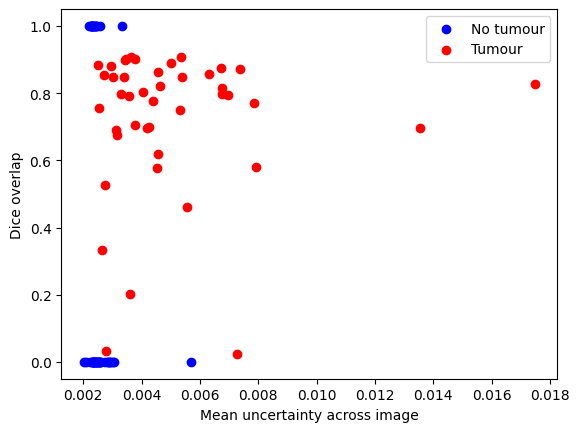

In [7]:
model_name ='ab_U_unc_oversample_128_U_autopet_folder0_DUloss_epoch_198.pth'
df_name = str(model_name)+'_test_results_2.csv'
results_df_ab_2=pd.read_csv(df_name)

df = results_df_ab_2

mask_class_0 = df['num_classes_list'] == 0
mask_class_1 = df['num_classes_list'] == 1

# Create a scatter plot for each group with different colors
plt.scatter(df[mask_class_0]['uncertainty_list'], df[mask_class_0]['dice_list'], label='No tumour', c='blue')
plt.scatter(df[mask_class_1]['uncertainty_list'], df[mask_class_1]['dice_list'], label='Tumour', c='red')

plt.xlabel('Mean uncertainty across image')
plt.ylabel('Dice overlap')
plt.legend()  # Add a legend to label the two groups

plt.show()

In [5]:
model_folder = 'test_output_2_ab_U_unc_oversample_128_U_autopet_folder0_DUloss_epoch_198.pth'

mean_uncertainties = []
image_names=[]
total_diff_coords=[]
uncertainty_values = []
uncertainty_values_correct = []
mean_uncertainties_correct=[]

for folder in os.listdir(model_folder):
    image_names.append(folder)

    for file in os.listdir(os.path.join(model_folder,folder)):
        if file == 'output.nii.gz':
            path = os.path.join(model_folder,folder,file)
            img_nifti = nib.load(path)
            output = img_nifti.get_fdata()
        if file == 'target.nii.gz':
            path = os.path.join(model_folder,folder,file)
            img_nifti = nib.load(path)
            target = img_nifti.get_fdata()
        if file == 'uncertainty.nii.gz':
            path = os.path.join(model_folder,folder,file)
            img_nifti = nib.load(path)
            uncertainty = img_nifti.get_fdata()
    diff_coordinates = np.argwhere(target - output != 0)
    correct_coordinates = np.argwhere(target - output == 0)

    # Iterate through coordinates with differences and collect uncertainty values
    for coord in diff_coordinates:
        uncertainty_value = uncertainty[tuple(coord)]
        uncertainty_values.append(uncertainty_value)

    for coord in correct_coordinates:
        uncertainty_value = uncertainty[tuple(coord)]
        uncertainty_values_correct.append(uncertainty_value)

    # Calculate the mean uncertainty value
    mean_uncertainty = np.mean(uncertainty_values)
    mean_uncertainties.append(mean_uncertainty)

    mean_uncertainty_correct = np.mean(uncertainty_values_correct)
    mean_uncertainties_correct.append(mean_uncertainty_correct)

    total_diff_coords.append(len(diff_coordinates))

    # get uncertainty values specifically at coordinates where there is a difference
    # return mean of those uncertainty vlaues


In [8]:
specific_unc = pd.DataFrame()
specific_unc['image'] = image_names
specific_unc['region_unc'] = mean_uncertainties
specific_unc['diff_coords']=total_diff_coords
specific_unc['correction_region_unc']=mean_uncertainties_correct

regional_df = results_df_ab_2.merge(specific_unc)

In [9]:
specific_unc['region_unc'].mean()

0.20348152200117353

In [10]:
specific_unc['correction_region_unc'].mean()

0.0033777369025507595

Text(0, 0.5, 'Model uncertainty')

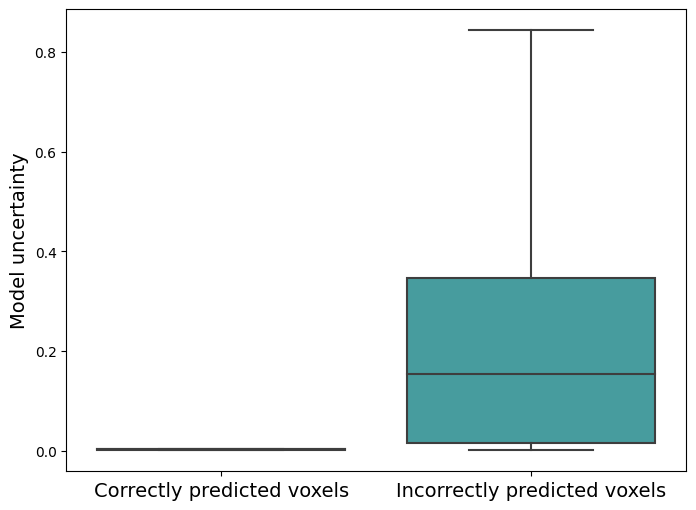

In [43]:
import seaborn as sns
plt.figure(figsize=(8, 6),facecolor='none')

sns.boxplot([uncertainty_values_correct,uncertainty_values],showfliers=False,palette='mako')
plt.xticks([0, 1], ['Correctly predicted voxels', 'Incorrectly predicted voxels'],fontsize=14)  # Replace 'Label 1' and 'Label 2' with your desired labels

# Add labels to the y-axis and the plot title
plt.ylabel('Model uncertainty',fontsize=14)

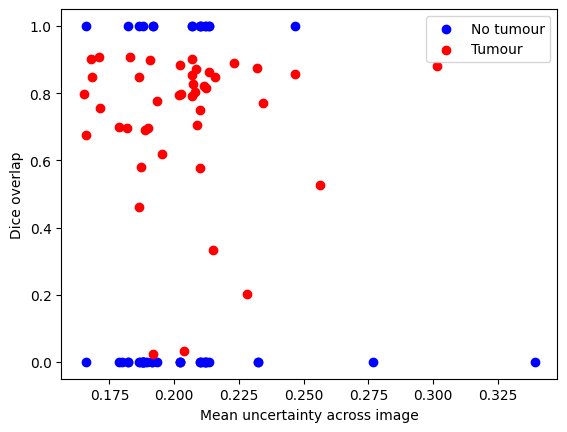

In [12]:
df = regional_df

mask_class_0 = df['num_classes_list'] == 0
mask_class_1 = df['num_classes_list'] == 1

# Create a scatter plot for each group with different colors
plt.scatter(df[mask_class_0]['region_unc'], df[mask_class_0]['dice_list'], label='No tumour', c='blue')
plt.scatter(df[mask_class_1]['region_unc'], df[mask_class_1]['dice_list'], label='Tumour', c='red')

plt.xlabel('Mean uncertainty across image')
plt.ylabel('Dice overlap')
plt.legend()  # Add a legend to label the two groups

plt.show()

In [13]:
## try getting dice score for pixels of different uncertainties
total_diff_3 = []
total_diff_2 = []
total_diff_1 = []
total_diff_0 = []

for folder in os.listdir(model_folder):
    print(folder)
    image_names.append(folder)
    
    path = os.path.join(model_folder,folder,'output.nii.gz')
    img_nifti = nib.load(path)
    output = img_nifti.get_fdata()
    
    path = os.path.join(model_folder,folder,'target.nii.gz')
    img_nifti = nib.load(path)
    target = img_nifti.get_fdata()
    
    path = os.path.join(model_folder,folder,'uncertainty.nii.gz')
    img_nifti = nib.load(path)
    uncertainty = img_nifti.get_fdata()

    uncertain_3_coords =  np.argwhere(uncertainty > 0.75)
    uncertain_2_coords = np.argwhere((0.5 < uncertainty) & (uncertainty <= 0.75))
    uncertain_1_coords = np.argwhere((0.25 < uncertainty) & (uncertainty <= 0.5))
    uncertain_0_coords =  np.argwhere(uncertainty <= 0.25)

    diff_3 = []

    for coord in uncertain_3_coords:
        pred = output[tuple(coord)]
        target_reg = target[tuple(coord)]
        diff_3.append(np.abs(pred-target_reg))

    if diff_3 != []:
        total_vox = 2*len(diff_3)
        inter_vox = 2*(len(diff_3) - np.sum(diff_3))
        total_diff_3.append(inter_vox/total_vox) 
        
    diff_2 = []

    for coord in uncertain_2_coords:
        pred = output[tuple(coord)]
        target_reg = target[tuple(coord)]
        diff_2.append(np.abs(pred-target_reg))

    if diff_2 != []:
        total_vox = 2*len(diff_2)
        inter_vox = 2*(len(diff_2) - np.sum(diff_2))
        total_diff_2.append(inter_vox/total_vox) 
    
    diff_1 = []

    for coord in uncertain_1_coords:
        pred = output[tuple(coord)]
        target_reg = target[tuple(coord)]
        diff_1.append(np.abs(pred-target_reg))
    
    if diff_1 != []:
        total_vox = 2*len(diff_1)
        inter_vox = 2*(len(diff_1) - np.sum(diff_1))
        total_diff_1.append(inter_vox/total_vox) 
        
    diff_0 = []

    for coord in uncertain_0_coords:
        pred = output[tuple(coord)]
        target_reg = target[tuple(coord)]
        diff_0.append(np.abs(pred-target_reg))
    
    if diff_0 != []:
        total_vox = 2*len(diff_0)
        inter_vox = 2*(len(diff_0) - np.sum(diff_0))
        total_diff_0.append(inter_vox/total_vox)
        

PETCT_c852dfc0a5_07262002
PETCT_b1aa7ce13e_03092003
PETCT_7b42056ee3_10132002
PETCT_41f4d41517_11132004
PETCT_f01e83894d_03242005
PETCT_f068e22258_05142007
PETCT_d69eabbb20_02012001
PETCT_88bcc970b3_02282002
PETCT_40f0749cb7_10062001
PETCT_d8d9e52cd5_05072007
PETCT_d3208ff062_03142003
PETCT_456d14846b_09012003
PETCT_0ea07b421b_10272001
PETCT_6d6a193655_11172002
PETCT_8e02f36295_11082004
PETCT_5ef99b0b6b_09072000
PETCT_1781ba966c_08082002
PETCT_2ad62beb52_03082003
PETCT_ede28cc3c2_01042001
PETCT_176bdc5388_06222006
PETCT_a90955352e_05162003
PETCT_4095c12e2d_11302006
PETCT_644d80e987_02152003
PETCT_ea0fd89f0f_10252003
PETCT_b66ba83594_03132003
PETCT_d325897ff4_07152005
PETCT_b3e923029c_11212003
PETCT_802f19931c_06302002
PETCT_c517c47bed_02062003
PETCT_dd8f9f217c_02152004
PETCT_9902caa7ec_08132006
PETCT_1472967bef_12212002
PETCT_9b982e72cb_09152001
PETCT_38a374d01a_05242007
PETCT_15a205ffcc_08192005
PETCT_f8314eb3f7_03142003
PETCT_ae6a37a9d6_08182005
PETCT_18e8b02af3_08142005
PETCT_b7c153

In [46]:
unc_bins_df = pd.DataFrame()
all_values = total_diff_3 + total_diff_2 + total_diff_1 + total_diff_0

# Create a list to categorize the values
categories = ['3'] * len(total_diff_3) + ['2'] * len(total_diff_2) + ['1'] * len(total_diff_1) + ['0'] * len(total_diff_0)

# Create a DataFrame
unc_bins_df = pd.DataFrame({'Values': all_values, 'Category': categories})

# Optionally, you can reset the index if needed
unc_bins_df.reset_index(drop=True, inplace=True)

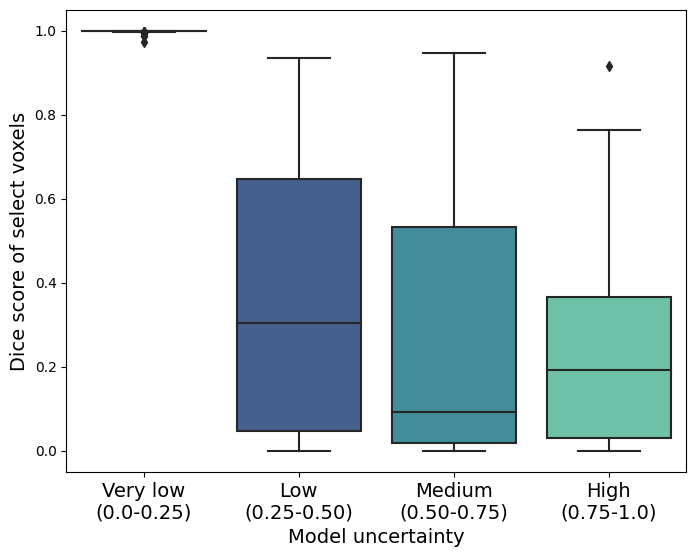

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your updated category mapping with line breaks
category_mapping = {
    '3': 'High\n(0.75-1.0)',
    '2': 'Medium\n(0.50-0.75)',
    '1': 'Low\n(0.25-0.50)',
    '0': 'Very low\n(0.0-0.25)'
}

unc_bins_df['Category'] = unc_bins_df['Category'].map(category_mapping)

category_order = ['Very low\n(0.0-0.25)', 'Low\n(0.25-0.50)', 'Medium\n(0.50-0.75)', 'High\n(0.75-1.0)']

# Create the figure with a transparent background
fig = plt.figure(figsize=(8, 6), facecolor='none')
ax = sns.boxplot(x='Category', y='Values', data=unc_bins_df, palette="mako", order=category_order)

# Set labels for the axes and the plot title with increased font size
plt.xlabel('Model uncertainty', fontsize=14)
plt.ylabel('Dice score of select voxels', fontsize=14)

# Increase the font size of x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

# Show the plot
plt.show()

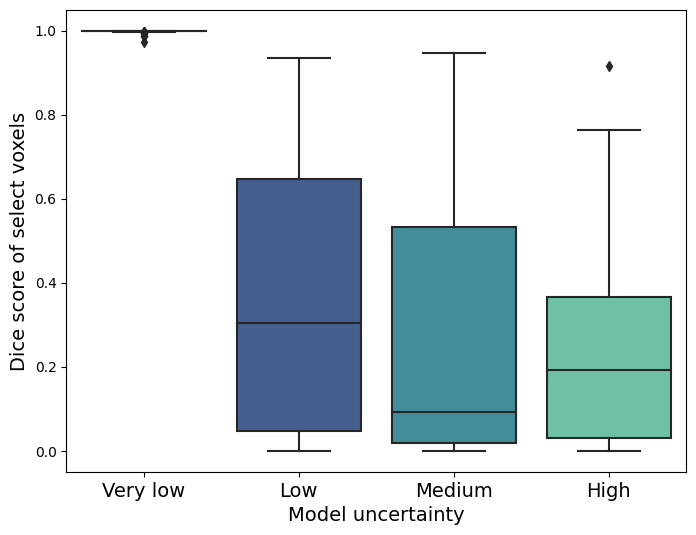

<Figure size 640x480 with 0 Axes>

In [40]:
category_mapping = {'3': 'High (0.75-1.0)', '2': 'Medium (0.50-0.75)' , '1': 'Low (0.25-0.50)', '0': 'Very low (0.0-0.25)'}
unc_bins_df['Category'] = unc_bins_df['Category'].map(category_mapping)

category_order = ['Very low (0.0-0.25)', 'Low (0.25-0.50)', 'Medium (0.50-0.75)', 'High (0.75-1.0)']

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6),facecolor='none')
sns.boxplot(x='Category', y='Values', data=unc_bins_df,palette="mako", order=category_order)

# Set labels for the axes and the plot title
plt.xlabel('Model uncertainty',fontsize=14)
plt.ylabel('Dice score of select voxels',fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

# Show the plot
plt.show()


In [16]:
unc_bins_df

,Values,Category
0,0.514793,High (0.75-1.0)
1,0.422892,High (0.75-1.0)
2,0.020000,High (0.75-1.0)
3,0.000000,High (0.75-1.0)
4,0.764479,High (0.75-1.0)
...,...,...
287,0.999487,Very low (0.0-0.25)
288,0.999346,Very low (0.0-0.25)
289,1.000000,Very low (0.0-0.25)
290,0.999914,Very low (0.0-0.25)
